In [52]:
import sys
sys.path.append("/Users/anuram/Documents/hydrogenase-ftir/src")

In [53]:
%load_ext autoreload
%autoreload 2

#Setting Up and Importing the Necessary Packages/Libraries
##Package for reading in Bruker OPUS type files
from brukeropusreader import read_file
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import pathlib
import numpy as np
import pandas as pd
#Local Functions
from hydrogenase_processing.cut_range import cut_range_subtraction
from hydrogenase_processing.second_deriv import second_deriv, first_deriv
#testing
#find peaks
from scipy.signal import find_peaks, peak_widths

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
#Paths to Local Data
path_to_water_vapor_data = pathlib.Path("../../data/opus_files/water_vapor")
path_to_output_plots_= pathlib.Path("../../data/output_plots/")
path_to_all_test_data = pathlib.Path("../../data/opus_files/subtraction_coefficient_testing") 

## Importing the Data form the local paths specified above ##

In [55]:
#Importing Water Vapor
wv_data = read_file(f'{path_to_water_vapor_data}''/water vapor 4cm-1.1')

In [56]:
#Pulling in all test data
second_derivative_test_raw_data = list(path_to_all_test_data.iterdir())
second_derivative_test_raw_data.sort()

#Initializing dict of raw spectra files from the file system
raw_data = dict()

#Populating the raw_test_data dict with all the read in raw opus files
for i in (second_derivative_test_raw_data):
    if not i.name.startswith('.DS_Store'):
        raw_data[i.name[0:4]] = read_file(i)

print(raw_data.keys())

dict_keys(['007_', '009_', '010_', '011_', '011a', '011b', '011c', '011d', '011e', '011f', '011g', '011h', '011i', '011k', '011l', '011m', '011n', '011o', '011p', '011q', '011r', '011s', '011t', '012_', '013_', '015_', '016_', '020_', '024_', '028_', '032_', '035_', '160 ', '162 ', '164 ', '165 ', '166 ', '167 ', '168 ', '169 ', '170 ', '171 ', '172 ', '173 ', '174 ', '175 ', '176 '])


In [57]:
test_comparisons_parameters_df = pd.read_excel("../../data/test_subtraction_coefficients.xlsx", sheet_name="uncut_samples")

#full_file_names = test_comparisons_parameters_df["file_name"]

test_comparisons_parameters_df["file_name"] = test_comparisons_parameters_df["file_name"].apply(lambda file_name: file_name[0:4]) 

#test_comparisons_parameters_df["file_name"] = exp_num_file_name


indexed_test_comparison_parameters = test_comparisons_parameters_df.set_index('file_name')
print(indexed_test_comparison_parameters)

           manual_subtraction_coefficient  pb_subtraction_coefficient  \
file_name                                                               
160                                   8.0                         NaN   
167                                   2.0                         NaN   
162                                   0.4                         NaN   
011a                                  1.0                         NaN   
011b                                  1.0                         NaN   
011c                                  3.0                         NaN   
011d                                  2.0                         NaN   
011e                                  4.0                         NaN   
011f                                  3.0                         NaN   
011g                                  1.0                         NaN   
011h                                  1.0                         NaN   
011i                                  2.0          

In [58]:
#Initializing dict of post water vapor subtraction spectra
cut_range_sub_wv_data = dict()

results = list()

for idx, row in indexed_test_comparison_parameters.iterrows():  
    print(idx)
    if idx in raw_data:
        raw_data_i = raw_data[idx]
        cut_range_sub_wv_data[f'{idx}_cut_range_wv_sub'] = cut_range_subtraction(raw_data_i, wv_data, row["range_start"], row["range_end"], SG_poly = 3, SG_points = 21)
        subtraction_parameters = cut_range_sub_wv_data[f'{idx}_cut_range_wv_sub'][0][0].fit_atm_params
        results.append(subtraction_parameters[0])
    else:
        results.append(None)

indexed_test_comparison_parameters["pb_subtraction_coefficient"] = results

160 
2150 1800
959 1141
167 
2150 1800
959 1141
162 
2150 1800
959 1141
011a
2150 1800
959 1141
011b
2150 1850
959 1115
011c
2150 1850
959 1115
011d
2150 1850
959 1115
011e
2150 1850
959 1115
011f
2150 1850
959 1115
011g
2150 1850
959 1115
011h
2150 1850
959 1115
011i
2150 1850
959 1115
011j
011k
2150 1850
959 1115
011l
2150 1850
959 1115
011m
2150 1850
959 1115
011n
2150 1850
959 1115
011o
2000 1800
1037 1141
011p
2000 1800
1037 1141
011q
2000 1800
1037 1141
011r
2000 1800
1037 1141
011s
2000 1800
1037 1141
011t
2000 1800
1037 1141
164 
2000 1800
1037 1141
165 
2000 1800
1037 1141
166 
2000 1800
1037 1141
168 
2000 1800
1037 1141
169 
2000 1800
1037 1141
170 
2000 1800
1037 1141
171 
2000 1800
1037 1141
172 
2000 1800
1037 1141
173 
2150 1850
959 1115
174 
2150 1850
959 1115
175 
2150 1850
959 1115
176 
2150 1850
959 1115


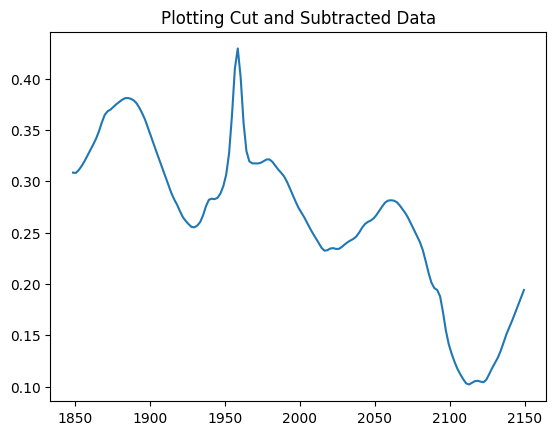

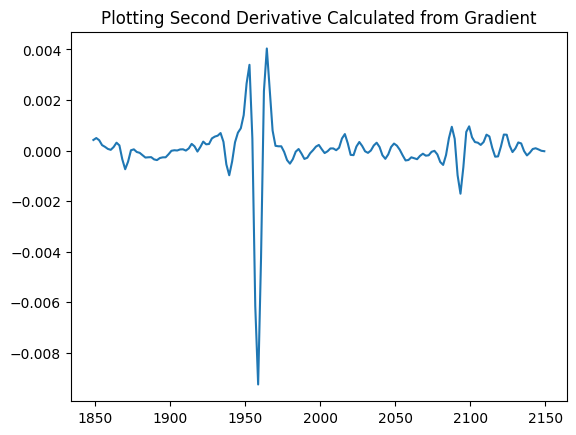

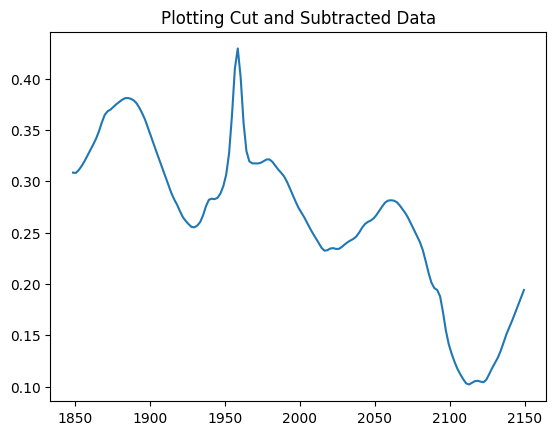

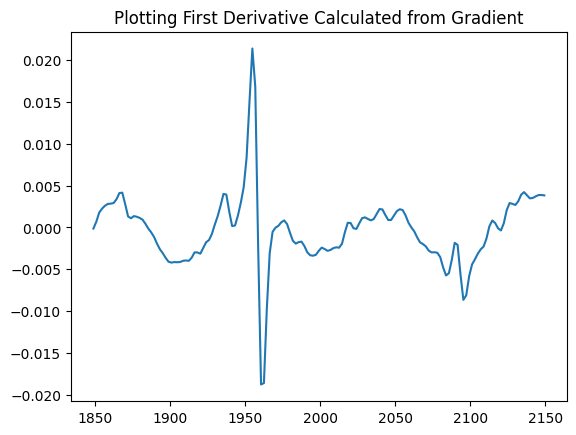

In [59]:
#Extracting wavenb and abs for one of the corrected spectra
example_cut_sub = cut_range_sub_wv_data["011b_cut_range_wv_sub"]

x = second_deriv(example_cut_sub, show_plots=True)


In [61]:
#because we want the peaks in the negative-y direction
d2ydx2_spl_upsidedown = x[1] * -1

#to determine what is the appropriate prominance parameter to use for different data
#attemptive method: calculate the peak height difference between each data points and take the average of the biggest 10 height difference results for the prominance parameter in find_peaks(), which gives a rough estimates of the signal scale

#function using for loop to subtract each data point with the next peak
peak_height_diff = []
for i in range(len(d2ydx2_spl_upsidedown)-1):    
    diff = d2ydx2_spl_upsidedown[i+1] - d2ydx2_spl_upsidedown[i]
    peak_height_diff.append(diff)

#sort the result list such that the peak height differences are listed from lowest to heighest
peak_height_diff.sort()

#average of top 10 data point height difference
mean_diff = np.mean(peak_height_diff[len(peak_height_diff)-10:len(peak_height_diff)])

In [62]:
top_ten_diffs = peak_height_diff[len(peak_height_diff)-10:len(peak_height_diff)]
relative_height = .15 * max(d2ydx2_spl_upsidedown)


In [63]:
#using the scipy peak finder to find peaks' indices in the 2nd derivative spline results
peaks_index = find_peaks(d2ydx2_spl_upsidedown, prominence=relative_height)

#use for loops to extract the coordinates of the peaks so we can plot them on the plot above
d2ydx2_peak_val = []
deriv_x_peak_val = []

for i in peaks_index[0]:
    d2ydx2_peak = x[1][i]
    deriv_x_peak = x[2][i]

    d2ydx2_peak_val.append(d2ydx2_peak)
    deriv_x_peak_val.append(deriv_x_peak)

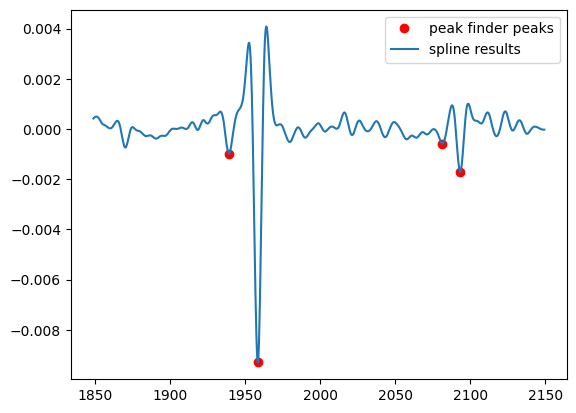

In [64]:
#plot the 2nd derivative with the peaks finder results
plt.plot(deriv_x_peak_val, d2ydx2_peak_val, "ro",label = "peak finder peaks")
plt.plot(x[2], x[1], label = "spline results")
plt.legend()

In [65]:
#get the peak widths
peak_wid = peak_widths(d2ydx2_spl_upsidedown, peaks_index[0], rel_height=1)


In [66]:
#Get the start index and end index along with the wave numbers
width_endIdx = [int(x) for x in peak_wid[2]]
wv_endIdx =[]
sec_dev_endIdx = []
for i in width_endIdx:
    wv_endIdx.append(x[2][i])
    sec_dev_endIdx.append(x[1][i])


width_startIdx = [int(x) for x in peak_wid[3]]
wv_startIdx = []
sec_dev_startIdx = []
for i in width_startIdx:
    wv_startIdx.append(x[2][i])
    sec_dev_startIdx.append(x[1][i])



/var/folders/l5/3xc64rz12wd5s3qlhgsnk0_h0000gn/T/ipykernel_71662/383433187.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(wv_startIdx, d2ydx2_spl_upsidedown[width_startIdx], 'ro', color = 'C2', label = 'start_idx')


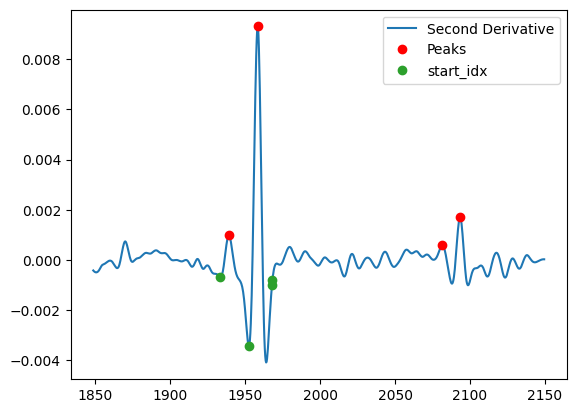

In [124]:
plt.plot(x[2], d2ydx2_spl_upsidedown, label='Second Derivative')
# Plot peaks on the second derivative plot
plt.plot(deriv_x_peak_val, d2ydx2_spl_upsidedown[peaks_index[0]], 'ro', label='Peaks')
plt.plot(wv_startIdx, d2ydx2_spl_upsidedown[width_startIdx], 'ro', color = 'C2', label = 'start_idx')
#plt.plot(wv_endIdx, d2ydx2_spl_upsidedown[width_endIdx], 'ro', color = 'C4', label = 'end_index')
plt.legend()

# Show the plot
plt.show()

In [127]:
print(wv_startIdx)
print(wv_endIdx)

[1967.9420604683485, 1968.2430517534094, 1952.5915049302432, 1933.3280626863464]
[2098.5722781847735, 2088.0375832076425, 1963.1261999073743, 1945.066722803721]


In [75]:
left_base = []
d2ydx2_leftBase = []
for i in peaks_index[1]['left_bases']:
    
    d2ydx2_leftBase.append(x[1][i])
    left_base.append(x[2][i])


print(left_base)

[2098.5722781847735, 2088.0375832076425, 1964.0291737625569, 1952.5915049302432]


In [80]:
right_base = []
d2ydx2_rightBase = []
for i in peaks_index[1]['right_bases']:
    
    d2ydx2_rightBase.append(x[1][i])
    right_base.append(x[2][i])


print(right_base)

[1964.0291737625569, 1964.0291737625569, 1952.5915049302432, 1933.3280626863464]


/var/folders/l5/3xc64rz12wd5s3qlhgsnk0_h0000gn/T/ipykernel_28136/2783634910.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(left_base, d2ydx2_leftBase, 'ro', color = 'C2')
/var/folders/l5/3xc64rz12wd5s3qlhgsnk0_h0000gn/T/ipykernel_28136/2783634910.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(right_base, d2ydx2_rightBase, 'ro', color = 'C4')


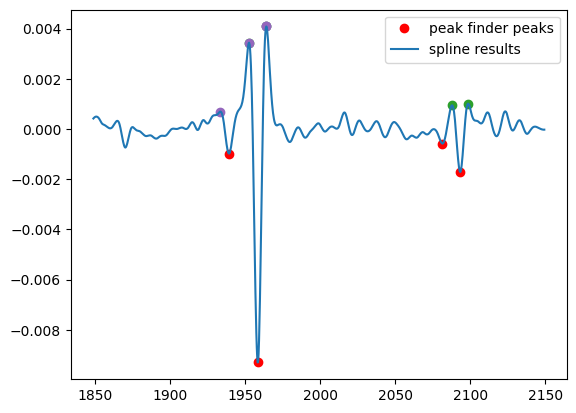

In [83]:
plt.plot(deriv_x_peak_val, d2ydx2_peak_val, "ro",label = "peak finder peaks")
plt.plot(left_base, d2ydx2_leftBase, 'ro', color = 'C2')
plt.plot(right_base, d2ydx2_rightBase, 'ro', color = 'C4')
plt.plot(x[2], x[1], label = "spline results")
plt.legend()

In [110]:
for wv in deriv_x_peak_val:
    mask = difference_df['wavenumber'] == int(wv)
    difference_df.loc[mask, 'startEndPeak'] = 'peak'


In [114]:
difference_df.loc[25:30]

,wavenumber,slope_1,slope_2,difference,startEndPeak
25,2101,-0.004438,-0.005834,0.001396,NA
26,2099,-0.005834,-0.008125,0.002291,NA
27,2097,-0.008125,-0.008670,0.000545,NA
28,2095,-0.008670,-0.005612,-0.003058,NA
29,2093,-0.005612,-0.002093,-0.003519,peak
30,2091,-0.002093,-0.001854,-0.000239,NA


In [117]:
difference_df.loc[30:39]

,wavenumber,slope_1,slope_2,difference,startEndPeak
30,2091,-0.002093,-0.001854,-0.000239,NA
31,2089,-0.001854,-0.003873,0.002019,NA
32,2087,-0.003873,-0.005474,0.001601,NA
33,2085,-0.005474,-0.005753,0.000279,NA
34,2083,-0.005753,-0.004786,-0.000967,NA
35,2081,-0.004786,-0.003562,-0.001224,peak
36,2080,-0.003562,-0.003040,-0.000522,NA
37,2078,-0.003040,-0.002972,-0.000068,NA
38,2076,-0.002972,-0.002994,0.000022,NA
39,2074,-0.002994,-0.002776,-0.000218,NA


In [118]:
difference_df.loc[95:101]

,wavenumber,slope_1,slope_2,difference,startEndPeak
95,1966,-0.003076,-0.009739,0.006663,NA
96,1964,-0.009739,-0.018628,0.008890,NA
97,1962,-0.018628,-0.018795,0.000167,NA
98,1960,-0.018795,-0.002273,-0.016522,NA
99,1958,-0.002273,0.016852,-0.019125,peak
100,1956,0.016852,0.021406,-0.004554,NA
101,1954,0.021406,0.015014,0.006392,NA


In [119]:
difference_df.loc[105:111]

,wavenumber,slope_1,slope_2,difference,startEndPeak
105,1947,0.002945,0.001417,0.001527,NA
106,1945,0.001417,0.000228,0.001190,NA
107,1943,0.000228,0.000156,0.000071,NA
108,1941,0.000156,0.001890,-0.001733,NA
109,1939,0.001890,0.003923,-0.002034,peak
110,1937,0.003923,0.004004,-0.000081,NA
111,1935,0.004004,0.002599,0.001405,NA


In [116]:
print(difference_df[difference_df['startEndPeak'] == 'peak'])

     wavenumber   slope_1   slope_2  difference startEndPeak
29         2093 -0.005612 -0.002093   -0.003519         peak
35         2081 -0.004786 -0.003562   -0.001224         peak
99         1958 -0.002273  0.016852   -0.019125         peak
109        1939  0.001890  0.003923   -0.002034         peak


In [125]:
print(difference_df[difference_df['wavenumber'] == 1952])

     wavenumber   slope_1   slope_2  difference startEndPeak
102        1952  0.015014  0.008341    0.006673           NA


In [161]:
data_tf = difference_df.loc[95:105]

data_tf.reset_index(inplace = True)
data_tf_2 = difference_df.loc[20:35]
data_tf_2.reset_index(inplace = True)

    index  wavenumber   slope_1   slope_2  difference startEndPeak
0      95        1966 -0.003076 -0.009739    0.006663           NA
1      96        1964 -0.009739 -0.018628    0.008890           NA
2      97        1962 -0.018628 -0.018795    0.000167           NA
3      98        1960 -0.018795 -0.002273   -0.016522           NA
4      99        1958 -0.002273  0.016852   -0.019125         peak
5     100        1956  0.016852  0.021406   -0.004554           NA
6     101        1954  0.021406  0.015014    0.006392           NA
7     102        1952  0.015014  0.008341    0.006673           NA
8     103        1950  0.008341  0.004809    0.003532           NA
9     104        1948  0.004809  0.002945    0.001864           NA
10    105        1947  0.002945  0.001417    0.001527           NA
    index  wavenumber   slope_1   slope_2  difference startEndPeak
0      95        1966 -0.003076 -0.009739    0.006663           NA
1      96        1964 -0.009739 -0.018628    0.008890   startO

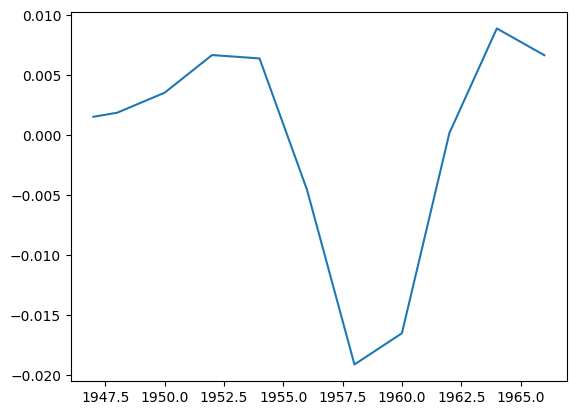

In [159]:
#print(data_tf.reset_index(inplace=True))
plt.plot(data_tf['wavenumber'], data_tf['difference'])

print(data_tf)
for i in range(1, len(data_tf)-1):
    if data_tf.loc[i, 'difference'] > data_tf.loc[i-1, 'difference'] and data_tf.loc[i, 'difference'] > data_tf.loc[i+1, 'difference']:
        data_tf.loc[i, 'startEndPeak'] = 'startOrEnd'
print(data_tf)

In [186]:
prev_diff = []
prev_diff= np.append(prev_diff, np.repeat(np.nan, 1))
prev_diff = np.append(prev_diff, data_tf.loc[0:len(data_tf)-2, 'difference'])
data_tf['prev_diff'] = prev_diff
next_diff = []
next_diff= np.append(next_diff, np.repeat(np.nan, 1))
next_diff = np.append(next_diff, data_tf.loc[2:len(data_tf)-1, 'difference'])
next_diff= np.append(next_diff, np.repeat(np.nan, 1))
print(len(next_diff))
data_tf['next_diff'] = next_diff
data_tf['testStartEnd'] = np.nan
mask = (data_tf['difference'] > data_tf['prev_diff']) & (data_tf['difference'] > data_tf['next_diff'])
data_tf.loc[mask, 'testStartEnd'] = 'startOrEnd'
data_tf

11


/var/folders/l5/3xc64rz12wd5s3qlhgsnk0_h0000gn/T/ipykernel_71662/2188094665.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tf['prev_diff'] = prev_diff
/var/folders/l5/3xc64rz12wd5s3qlhgsnk0_h0000gn/T/ipykernel_71662/2188094665.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tf['next_diff'] = next_diff
/var/folders/l5/3xc64rz12wd5s3qlhgsnk0_h0000gn/T/ipykernel_71662/2188094665.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

,index,wavenumber,slope_1,slope_2,difference,startEndPeak,prev_diff,next_diff,testStartEnd
0,95,1966,-0.003076,-0.009739,0.006663,NA,NaN,NaN,NaN
1,96,1964,-0.009739,-0.018628,0.008890,startOrEnd,0.006663,0.000167,startOrEnd
2,97,1962,-0.018628,-0.018795,0.000167,NA,0.008890,-0.016522,NaN
3,98,1960,-0.018795,-0.002273,-0.016522,NA,0.000167,-0.019125,NaN
4,99,1958,-0.002273,0.016852,-0.019125,peak,-0.016522,-0.004554,NaN
5,100,1956,0.016852,0.021406,-0.004554,NA,-0.019125,0.006392,NaN
6,101,1954,0.021406,0.015014,0.006392,NA,-0.004554,0.006673,NaN
7,102,1952,0.015014,0.008341,0.006673,startOrEnd,0.006392,0.003532,startOrEnd
8,103,1950,0.008341,0.004809,0.003532,NA,0.006673,0.001864,NaN
9,104,1948,0.004809,0.002945,0.001864,NA,0.003532,0.001527,NaN


#Slope based anchor point detection


In [200]:
_, slope = first_deriv(example_cut_sub, show_plots=False)
x_wavenb = [int(x) for x in example_cut_sub[0][0].wavenb]


y = slope[1:]
y = np.append(y, np.repeat(np.nan, 1))
print(len(y), len(slope), len(x_wavenb))
data = {'wavenumber': x_wavenb,'slope_1': slope, 'slope_2': y}
difference_df = pd.DataFrame(data)
difference_df['difference'] = difference_df['slope_1'] - difference_df['slope_2']
difference_df['startEndPeak'] = np.nan


prev_diff = []
prev_diff= np.append(prev_diff, np.repeat(np.nan, 1))
prev_diff = np.append(prev_diff, difference_df.loc[0:len(difference_df)-2, 'difference'])
difference_df['prev_diff'] = prev_diff
next_diff = []
next_diff= np.append(next_diff, np.repeat(np.nan, 1))
next_diff = np.append(next_diff, difference_df.loc[2:len(difference_df)-1, 'difference'])
next_diff= np.append(next_diff, np.repeat(np.nan, 1))

difference_df['next_diff'] = next_diff



for wv in deriv_x_peak_val:
    mask = difference_df['wavenumber'] == int(wv)
    difference_df.loc[mask, 'startEndPeak'] = 'peak'


mask = (difference_df['difference'] > difference_df['prev_diff']) & (difference_df['difference'] > difference_df['next_diff'])
difference_df.loc[mask, 'startEndPeak'] = 'startOrEnd'

difference_df

157 157 157


,wavenumber,slope_1,slope_2,difference,startEndPeak,prev_diff,next_diff
0,2149,0.003827,0.003878,-0.000051,NaN,NaN,NaN
1,2147,0.003878,0.003866,0.000012,NaN,-0.000051,0.000156
2,2145,0.003866,0.003710,0.000156,NaN,0.000012,0.000195
3,2143,0.003710,0.003515,0.000195,startOrEnd,0.000156,0.000040
4,2141,0.003515,0.003475,0.000040,NaN,0.000195,-0.000363
...,...,...,...,...,...,...,...
152,1856,0.002589,0.002241,0.000348,NaN,0.000220,0.000477
153,1854,0.002241,0.001764,0.000477,NaN,0.000348,0.001100
154,1852,0.001764,0.000664,0.001100,startOrEnd,0.000477,0.000805
155,1850,0.000664,-0.000141,0.000805,NaN,0.001100,NaN


In [201]:
print(difference_df[difference_df['startEndPeak'] == 'startOrEnd'])

     wavenumber   slope_1   slope_2  difference startEndPeak  prev_diff  \
3          2143  0.003710  0.003515    0.000195   startOrEnd   0.000156   
8          2134  0.003916  0.003135    0.000781   startOrEnd   0.000304   
13         2124  0.002067  0.000503    0.001564   startOrEnd   0.000847   
19         2112  0.000132 -0.001324    0.001456   startOrEnd   0.000693   
23         2105 -0.003145 -0.003819    0.000674   startOrEnd   0.000522   
26         2099 -0.005834 -0.008125    0.002291   startOrEnd   0.001396   
31         2089 -0.001854 -0.003873    0.002019   startOrEnd  -0.000239   
38         2076 -0.002972 -0.002994    0.000022   startOrEnd  -0.000068   
42         2068 -0.001994 -0.001788   -0.000206   startOrEnd  -0.000277   
45         2062 -0.000470 -0.000002   -0.000468   startOrEnd  -0.000714   
52         2049  0.001427  0.000888    0.000539   startOrEnd   0.000526   
58         2037  0.001607  0.001006    0.000602   startOrEnd   0.000591   
64         2026  0.000506

In [204]:
peak_data = difference_df[difference_df['startEndPeak'] == 'peak']
peak_data

,wavenumber,slope_1,slope_2,difference,startEndPeak,prev_diff,next_diff
29,2093,-0.005612,-0.002093,-0.003519,peak,-0.003058,-0.000239
35,2081,-0.004786,-0.003562,-0.001224,peak,-0.000967,-0.000522
99,1958,-0.002273,0.016852,-0.019125,peak,-0.016522,-0.004554
109,1939,0.001890,0.003923,-0.002034,peak,-0.001733,-0.000081


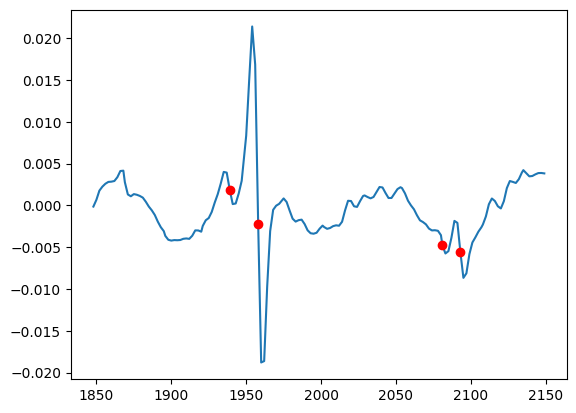

In [231]:
plt.plot(x_wavenb,slope)
plt.plot(peak_data['wavenumber'], peak_data['slope_1'], 'ro')


Empty DataFrame
Columns: [wavenumber, second_deriv]
Index: []


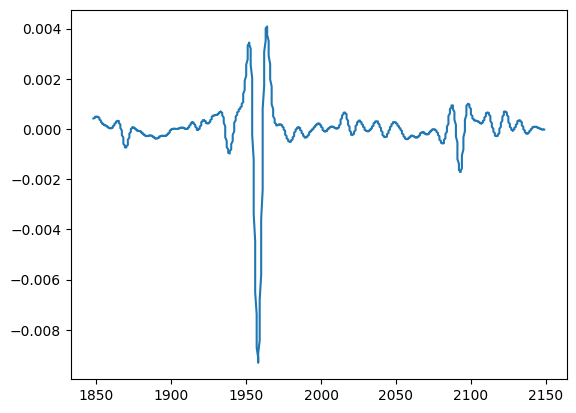

In [247]:
dy2dx2_data = pd.DataFrame({'wavenumber': x[2], 'second_deriv': x[1]})

second_wv = [int(a) for a in dy2dx2_data['wavenumber']]
peak_wv = peak_data['wavenumber']
peak_second = []
print(dy2dx2_data[dy2dx2_data['wavenumber'] == 2081])
for wv in peak_wv:

    mask = dy2dx2_data['wavenumber'] == wv
    peak_second.append(dy2dx2_data.loc[mask, 'second_deriv'])


plt.plot(second_wv, x[1])
#plt.plot(peak_wv, peak_second)


In [228]:
wavenumber = [int(x) for x in example_cut_sub[0][0].wavenb ]
spectra_data = pd.DataFrame({'wavenumber' : wavenumber , 'absorbance' : example_cut_sub[0][0].sub_spectrum})
test = spectra_data[spectra_data['wavenumber'] == 2093]
test2 = spectra_data[spectra_data['wavenumber'] == 2081]
test3 = spectra_data[spectra_data['wavenumber'] == 1958]
test4 = spectra_data[spectra_data['wavenumber'] == 1939]

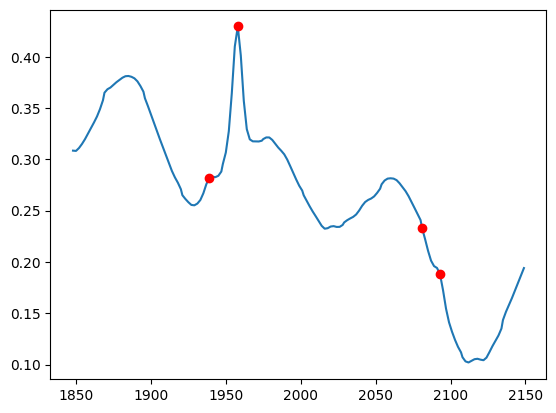

In [229]:
plt.plot(spectra_data['wavenumber'], spectra_data['absorbance'])
plt.plot(test['wavenumber'], test['absorbance'], 'ro')
plt.plot(test2['wavenumber'], test2['absorbance'], 'ro')
plt.plot(test3['wavenumber'], test3['absorbance'], 'ro')
plt.plot(test4['wavenumber'], test4['absorbance'], 'ro')

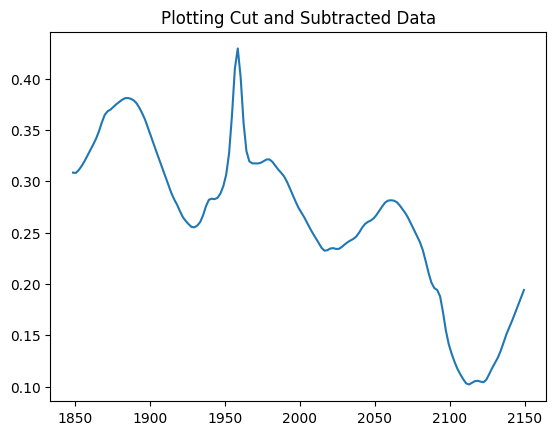

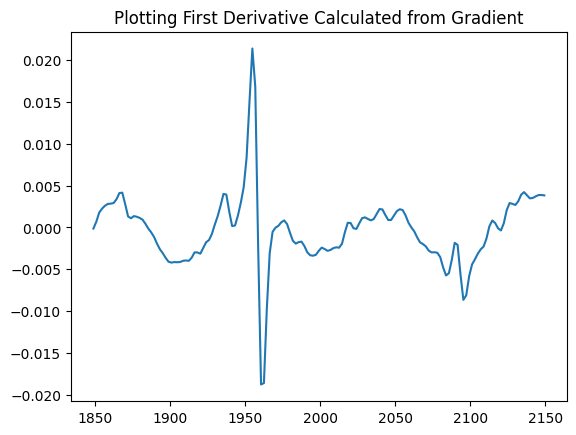

In [207]:
_, slope = first_deriv(example_cut_sub, show_plots=True)